In [1]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import math
from datetime import date

In [2]:
# Call API and create dataframe

response = requests.get("https://api.covid19india.org/csv/latest/state_wise_daily.csv")
df = pd.read_csv(io.StringIO(response.text), delimiter=",")
df.drop(df[df["Date_YMD"] == str(date.today())].index, inplace=True)
display(df)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,0,0,0,7,0,0,14,0,2,0,6,19,0,0,0,14,0,0,0,0,0,0,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,18,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,25-May-21,2021-05-25,Recovered,295264,49,20917,231,4783,6015,618,7893,51,0,4251,2082,9676,6720,3067,3623,3155,38224,33397,179,104,7373,36176,468,755,141,161,11769,1571,6451,15635,87,28745,4298,427,10441,6674,19057,0
1313,25-May-21,2021-05-25,Deceased,4160,2,106,2,92,104,5,77,0,0,156,39,44,128,60,53,20,588,177,1,2,68,1137,15,19,1,18,33,26,174,105,5,468,23,5,157,93,157,0
1314,26-May-21,2021-05-26,Confirmed,211510,23,18285,374,5699,2603,224,2829,14,0,1491,1487,3085,3138,1365,3037,977,26811,28798,235,118,2182,24752,847,846,316,260,11623,1321,4004,3886,295,33764,3762,667,3176,2991,16225,0
1315,26-May-21,2021-05-26,Recovered,283054,29,24105,190,6266,6641,706,5767,53,0,3952,1363,10007,5476,2196,4023,2403,40738,35525,130,190,7479,23065,379,752,132,131,10635,1927,6397,13192,242,29717,3816,965,10540,4854,19071,0


In [3]:
# State codes

state_codes = list(df.columns)[4:-1]
print("Number of States & UTs:", len(state_codes))
print(state_codes)

Number of States & UTs: 37
['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG', 'TR', 'UP', 'UT', 'WB']


In [4]:
# Handle negative counts

negative_count = 0

for i in range(len(df)):
    for j in range(4, 41):
        if df.iloc[i, j] < 0:
            negative_count += 1
            if j == 4:
                df.iloc[i, j] = 0
            elif j == 5:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 6:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 38:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 39:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 40:
                avg = df.iloc[i, j-7:j].mean()
                df.iloc[i, j] = math.floor((avg / df.iloc[i, j-7]) * avg)
            else:
                df.iloc[i, j] = math.floor((df.iloc[i, j-3:j].sum() + df.iloc[i, j+1:j+4].sum()) / 6)

print("Total negative count:", negative_count)

Total negative count: 16


In [5]:
# Create active cases dataframe

active = pd.DataFrame(columns=df.columns)

running_confirmed = [0] * len(df.loc[0][3:])
running_recovered = [0] * len(df.loc[1][3:])
running_deceased = [0] * len(df.loc[2][3:])

for row in range(len(df)):
    if df.loc[row]["Status"] == "Confirmed":
        running_confirmed += df.loc[row][3:]
    elif df.loc[row]["Status"] == "Recovered":
        running_recovered += df.loc[row][3:]
    else:
        running_deceased += df.loc[row][3:]
        active.loc[len(active)] = [df.loc[row]["Date"], df.loc[row]["Date_YMD"], "Active"] + list(running_confirmed - running_recovered - running_deceased)

active = active.infer_objects()
display(active)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Active,70,0,1,0,0,0,0,0,0,0,5,0,0,14,0,2,0,5,16,0,0,0,14,0,0,0,0,0,0,1,2,0,1,1,0,8,0,0,0
1,15-Mar-20,2020-03-15,Active,93,0,1,0,0,0,0,0,0,0,4,0,0,14,0,2,0,5,21,0,0,0,32,0,0,0,0,0,0,1,1,0,1,2,0,9,0,0,0
2,16-Mar-20,2020-03-16,Active,107,0,1,0,0,0,0,0,0,0,4,0,0,14,0,3,0,6,24,0,0,0,38,0,0,0,0,1,1,1,1,0,0,3,0,9,1,0,0
3,17-Mar-20,2020-03-17,Active,116,0,1,0,0,0,0,0,0,0,5,0,0,15,0,3,0,8,24,0,0,0,40,0,0,0,0,1,1,1,1,0,0,4,0,10,1,1,0
4,18-Mar-20,2020-03-18,Active,153,0,1,0,0,0,0,0,0,0,7,0,0,16,0,4,0,13,24,8,0,0,43,0,0,0,0,2,1,2,4,0,1,12,0,12,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,22-May-21,2021-05-22,Active,2810211,283,210683,2937,55297,44908,5265,70540,558,0,31308,18243,80126,47994,28812,49136,22534,483217,289662,1516,2023,62052,360957,6383,8164,2239,5166,99038,17342,61319,122330,2318,284278,42449,7563,94480,63347,131658,0
435,23-May-21,2021-05-23,Active,2726338,273,209237,2900,53003,40692,4874,65774,526,0,27610,17277,75133,42817,26003,47437,19467,472999,277978,1522,2075,57765,357132,6527,8392,2348,5238,100235,16853,57621,112218,2441,294143,39979,8237,84878,60153,130495,0
436,24-May-21,2021-05-24,Active,2591949,259,203762,3128,53888,37943,4428,60938,496,0,24578,16278,68970,38120,24205,45630,17537,440448,259564,1463,2187,53652,336342,6437,8498,2280,5280,99648,15837,55112,99875,2310,301580,38696,8187,76701,55051,128555,0
437,25-May-21,2021-05-25,Active,2501517,233,198023,3324,54780,35130,4063,56474,479,0,21739,15706,62505,34089,23077,44918,15609,424394,255793,1561,2345,48633,323165,6778,8681,2427,5377,98785,15477,53243,87539,2496,306652,38196,8528,69826,51040,126346,0


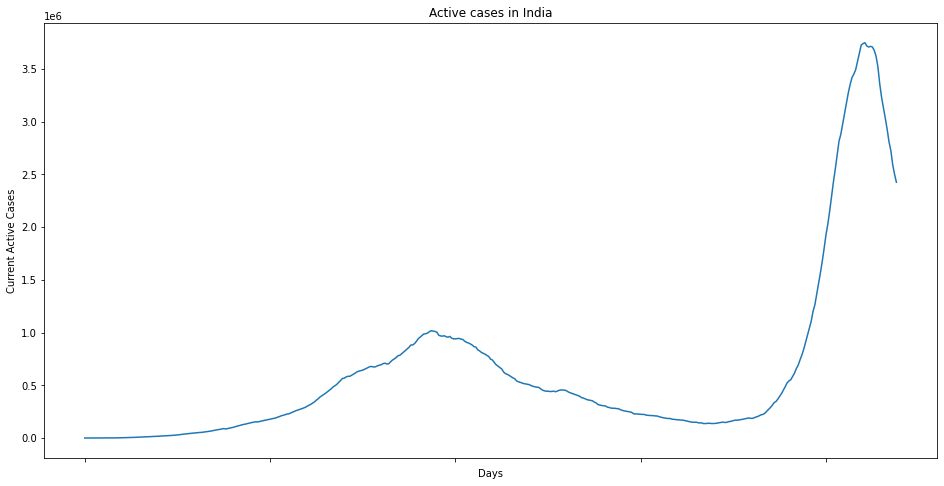

In [6]:
# Active cases in India

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=active["TT"])
g.set(xticklabels=[])
g.set(title="Active cases in India")
g.set(xlabel="Days")
g.set(ylabel="Current Active Cases")
plt.show()

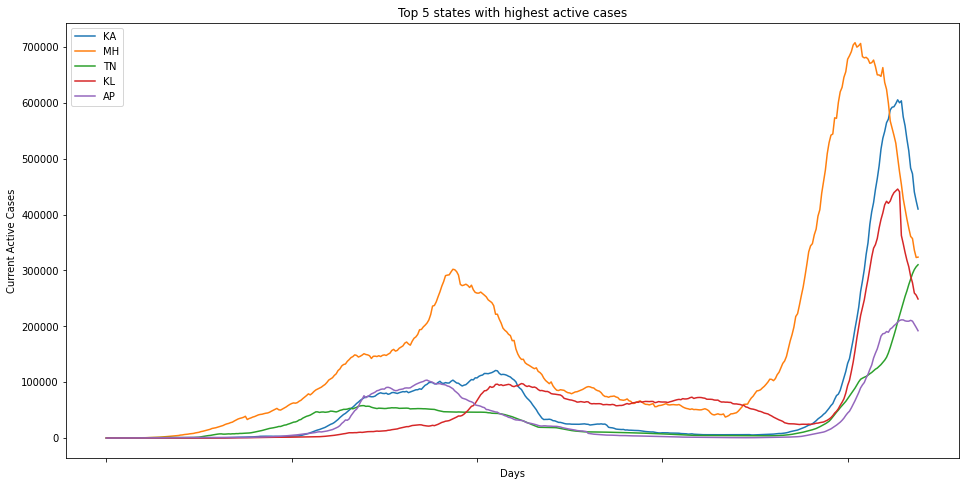

In [7]:
# Top 5 states with highest active cases

states = {}
for state in state_codes:
     states[state] = active.loc[len(active)-1][state]

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=active[states], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest active cases")
g.set(xlabel="Days")
g.set(ylabel="Current Active Cases")
plt.show()

In [8]:
# Segregate confirmed, recovered and deceased cases

confirmed = df.loc[df["Status"] == "Confirmed"]
recovered = df.loc[df["Status"] == "Recovered"]
deceased = df.loc[df["Status"] == "Deceased"]

display(confirmed)
display(recovered)
display(deceased)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,0,0,0,7,0,0,14,0,2,0,6,19,0,0,0,14,0,0,0,0,0,0,1,3,0,1,1,0,12,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,18,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0
6,16-Mar-20,2020-03-16,Confirmed,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,6,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0
9,17-Mar-20,2020-03-17,Confirmed,11,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0
12,18-Mar-20,2020-03-18,Confirmed,37,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,5,0,8,0,0,3,0,0,0,0,1,0,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,22-May-21,2021-05-22,Confirmed,240897,31,19981,314,5980,4375,392,4328,34,0,2260,1647,4205,5021,2341,3408,2037,31183,28514,131,317,3844,26133,757,1123,274,252,11108,1445,5297,6103,287,35873,3308,864,5964,2903,18863,0
1305,23-May-21,2021-05-23,Confirmed,222834,24,18767,226,3563,4002,360,3306,30,0,1649,1621,3794,4400,1309,3308,1345,25979,25820,130,193,3375,26672,767,803,214,223,12852,1448,5021,6521,324,35483,2242,876,4715,3050,18422,0
1308,24-May-21,2021-05-24,Confirmed,195857,9,12994,480,6221,2844,245,4209,16,0,1550,1401,3187,3757,1949,2237,1394,25311,17821,125,236,2936,22122,538,811,112,191,11059,922,4481,4414,101,34867,3043,426,3894,2071,17883,0
1311,25-May-21,2021-05-25,Confirmed,208992,25,15284,429,5767,3306,258,3506,34,0,1568,1549,3255,2817,1999,2964,1247,22758,29803,278,264,2422,24136,824,957,289,276,10939,1237,4756,3404,278,34285,3821,773,3723,2756,17005,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0
7,16-Mar-20,2020-03-16,Recovered,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10,17-Mar-20,2020-03-17,Recovered,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
13,18-Mar-20,2020-03-18,Recovered,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,22-May-21,2021-05-22,Recovered,355138,24,18336,291,4659,8676,790,10131,72,0,6453,2693,8445,11327,5021,4117,3929,61766,45400,211,143,9327,40294,652,509,215,214,10601,2011,7363,15464,267,25776,4723,332,17540,8164,19202,0
1306,23-May-21,2021-05-23,Recovered,302253,32,20109,260,5785,8111,741,7980,62,0,5158,2545,8734,9480,4059,4956,4375,35573,37316,122,141,7587,29177,609,553,103,137,11627,1903,8527,16520,198,25196,4693,196,14086,6173,19429,0
1309,24-May-21,2021-05-24,Recovered,326737,22,18373,248,5252,5500,684,8985,46,0,4375,2362,9305,8359,3686,3999,3291,57333,36039,184,124,6989,42320,611,679,180,137,11614,1915,6803,16654,224,27026,4305,474,11918,7051,19670,0
1312,25-May-21,2021-05-25,Recovered,295264,49,20917,231,4783,6015,618,7893,51,0,4251,2082,9676,6720,3067,3623,3155,38224,33397,179,104,7373,36176,468,755,141,161,11769,1571,6451,15635,87,28745,4298,427,10441,6674,19057,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,15-Mar-20,2020-03-15,Deceased,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,16-Mar-20,2020-03-16,Deceased,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,17-Mar-20,2020-03-17,Deceased,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,18-Mar-20,2020-03-18,Deceased,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,22-May-21,2021-05-22,Deceased,3739,3,118,3,79,103,12,103,0,0,182,39,54,98,55,48,41,451,176,3,2,89,682,13,21,1,13,26,30,201,115,1,448,21,2,218,134,154,0
1307,23-May-21,2021-05-23,Deceased,4454,2,104,3,72,107,10,92,0,0,189,42,53,97,59,51,37,624,188,2,0,75,1320,14,22,2,14,28,34,192,113,3,422,19,6,231,71,156,0
1310,24-May-21,2021-05-24,Deceased,3509,1,96,4,84,93,7,60,0,0,207,38,45,95,61,45,33,529,196,0,0,60,592,17,26,0,12,32,23,187,103,8,404,21,2,153,122,153,0
1313,25-May-21,2021-05-25,Deceased,4160,2,106,2,92,104,5,77,0,0,156,39,44,128,60,53,20,588,177,1,2,68,1137,15,19,1,18,33,26,174,105,5,468,23,5,157,93,157,0


In [9]:
# Calculate total active, confirmed, recovered and deceased cases

print("Total Active Cases:", list(active["TT"])[-1])
print("Total Confirmed Cases:", confirmed["TT"].sum())
print("Total Recovered Cases:", recovered["TT"].sum())
print("Total Deceased Cases:", deceased["TT"].sum())

Total Active Cases: 2426130
Total Confirmed Cases: 27367312
Total Recovered Cases: 24625913
Total Deceased Cases: 315269


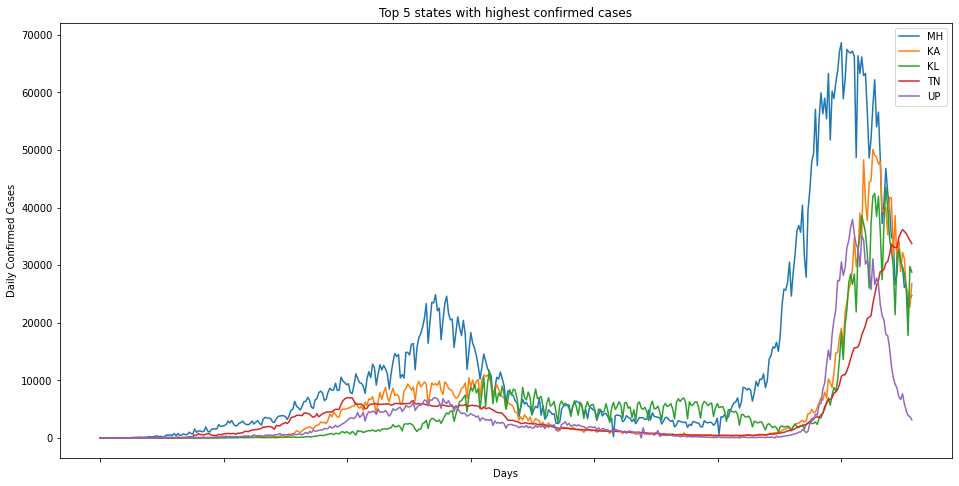

In [10]:
# Top 5 states with highest confirmed cases

states = {}
for state in state_codes:
     states[state] = confirmed[state].sum()

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=confirmed[states], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest confirmed cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Confirmed Cases")
plt.show()

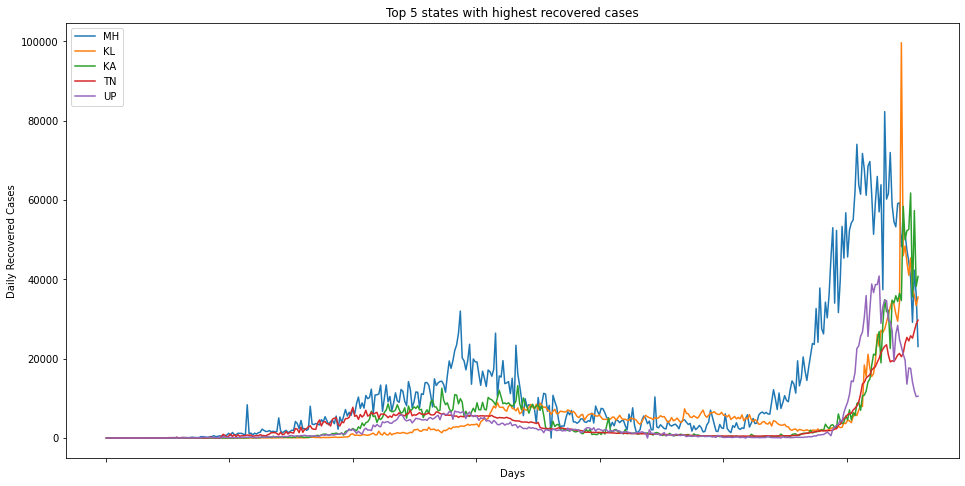

In [11]:
# Top 5 states with highest recovered cases

states = {}
for state in state_codes:
    states[state] = recovered[state].sum() 

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=recovered[states], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest recovered cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Recovered Cases")
plt.show()

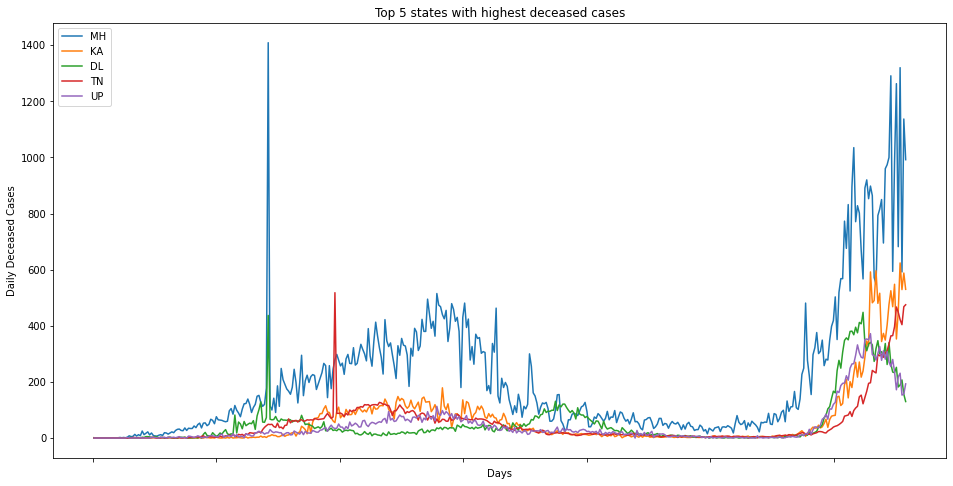

In [12]:
# Top 5 states with highest deceased cases

states = {}
for state in state_codes:
    states[state] = deceased[state].sum() 

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=deceased[states], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest deceased cases")
g.set(xlabel="Days")
g.set(ylabel="Daily Deceased Cases")
plt.show()

In [13]:
# Daily percentage contribution

daily_percentage = confirmed.copy()

for idx in range(len(daily_percentage)):
    daily_percentage.iloc[idx, 4:] = (daily_percentage.iloc[idx, 4:] / daily_percentage.iloc[idx, 3]) * 100

daily_percentage.drop(columns=["Date", "Status", "TT", "UN"], inplace=True)
display(daily_percentage)

,Date_YMD,AN,AP,AR,AS,BR,CH,CT,DN,DD,DL,GA,GJ,HR,HP,JK,JH,KA,KL,LA,LD,MP,MH,MN,ML,MZ,NL,OR,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
0,2020-03-14,0.000000,1.234568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.641975,0.000000,0.000000,17.283951,0.000000,2.469136,0.000000,7.407407,23.456790,0.000000,0.000000,0.000000,17.283951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.234568,3.703704,0.000000,1.234568,1.234568,0.000000,14.814815,0.000000,0.000000
3,2020-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.518519,0.000000,0.000000,0.000000,66.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.703704,0.000000,0.000000,7.407407,0.000000,3.703704,0.000000,0.000000
6,2020-03-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.666667,0.000000,6.666667,20.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,6.666667,6.666667,0.000000,0.000000,0.000000,0.000000,6.666667,0.000000,0.000000,6.666667,0.000000
9,2020-03-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.090909,0.000000,0.000000,9.090909,0.000000,0.000000,0.000000,18.181818,0.000000,0.000000,0.000000,0.000000,27.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.090909,0.000000,18.181818,0.000000,9.090909
12,2020-03-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.405405,0.000000,0.000000,2.702703,0.000000,2.702703,0.000000,13.513514,0.000000,21.621622,0.000000,0.000000,8.108108,0.000000,0.000000,0.000000,0.000000,2.702703,0.000000,2.702703,8.108108,0.000000,2.702703,21.621622,0.000000,5.405405,2.702703,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,2021-05-22,0.012869,8.294416,0.130346,2.482389,1.816129,0.162725,1.796618,0.014114,0.0,0.938160,0.683695,1.745559,2.084293,0.971785,1.414713,0.845590,12.944536,11.836594,0.054380,0.131592,1.595703,10.848205,0.314242,0.466174,0.113742,0.104609,4.611099,0.599841,2.198865,2.533448,0.119138,14.891427,1.373201,0.358660,2.475747,1.205079,7.830318
1305,2021-05-23,0.010770,8.421964,0.101421,1.598948,1.795956,0.161555,1.483616,0.013463,0.0,0.740013,0.727447,1.702613,1.974564,0.587433,1.484513,0.603588,11.658454,11.587101,0.058339,0.086612,1.514580,11.969448,0.344202,0.360358,0.096036,0.100074,5.767522,0.649811,2.253247,2.926394,0.145400,15.923513,1.006130,0.393118,2.115925,1.368732,8.267141
1308,2021-05-24,0.004595,6.634432,0.245077,3.176297,1.452080,0.125091,2.149017,0.008169,0.0,0.791394,0.715318,1.627208,1.918236,0.995114,1.142160,0.711744,12.923204,9.098985,0.063822,0.120496,1.499053,11.294975,0.274690,0.414078,0.057185,0.097520,5.646467,0.470752,2.287894,2.253685,0.051568,17.802274,1.553685,0.217506,1.988185,1.057404,9.130641
1311,2021-05-25,0.011962,7.313199,0.205271,2.759436,1.581879,0.123450,1.677576,0.016269,0.0,0.750268,0.741177,1.557476,1.347898,0.956496,1.418236,0.596674,10.889412,14.260354,0.133019,0.126321,1.158896,11.548767,0.394273,0.457912,0.138283,0.132062,5.234172,0.591889,2.275685,1.628770,0.133019,16.404934,1.828300,0.369871,1.781408,1.318711,8.136675


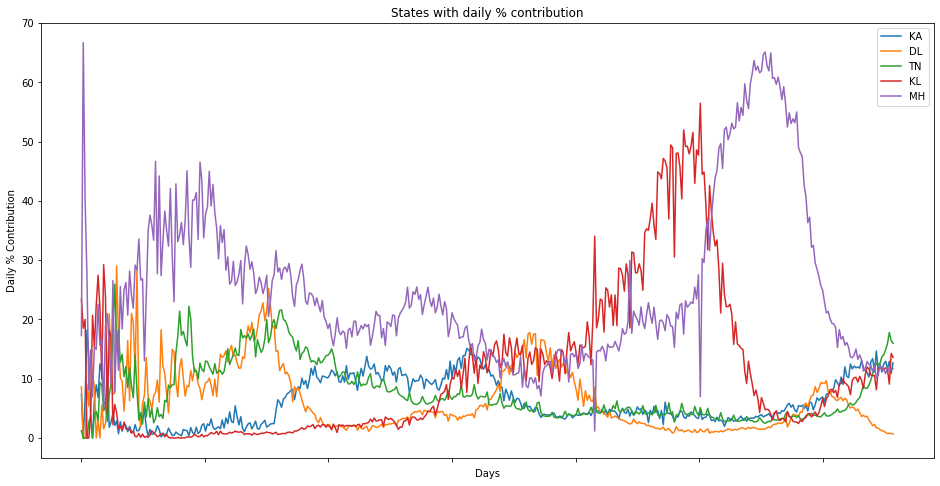

In [14]:
# Top 5 daily contributing states

daily_mean = dict.fromkeys(state_codes, 0)
for state in state_codes:
    daily_mean[state] = daily_percentage[state].mean()

top_five_daily = dict(sorted(daily_mean.items(), key=lambda item: item[1]))
top_five_daily = list(top_five_daily.keys())[-5:]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.lineplot(data=daily_percentage[top_five_daily], dashes=False)
g.set(xticklabels=[])
g.set(title="States with daily % contribution")
g.set(xlabel="Days")
g.set(ylabel="Daily % Contribution")
plt.show()